In [1]:
# Import Libraries
import os
import numpy as np
import pipeline as pl
import tensorflow as tf
import pandas as pd
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sn

In [2]:
train_desc = pd.read_csv('temp/withoneattr_train.csv')

In [3]:
train_desc.loc[0]

id                                                               2
product_uid                                                 100001
product_title                    Simpson Strong-Tie 12-Gauge Angle
search_term                                          angle bracket
relevance                                                        3
name                                                      Bullet01
value            Versatile connector for various 90° connection...
Name: 0, dtype: object

## Preprocessing Data

In [4]:
def corpus(filename='temp/train_product_desc.csv'):
    import csv
    reader = csv.reader(open(filename))
    data = []
    for row in reader:
        i_d,product_uid,product_title,search_term,relevance, product_description= row
        dic = {'search_term':search_term, 'product_title': product_title,'relevance': relevance,\
               'desc':product_description}
        data.append(dic)
    del data[0]
    return data

def tokenise(input):
    return input.split(' ')

def pipeline(data,vocab=None, max_title_len_=None, max_query_len_=None,max_attr_len_=None):
    
    # Vocab
    exist_vocab = True
    if vocab is None:
        exist_vocab = False
        vocab = {'<PAD>': 0, '<OOV>':1}
    
    ## Placeholder ## 
    
    # Product Title
    max_title_len = -1
    data_title = []
    # Search Term
    max_query_len = -1
    data_query = []
    # Attr Term
    max_attr_len = -1
    data_attr = []
    
    # Relevance
    data_relevance = []
    
    ## Processing ## 
    for instance in data:
        # Product Title Processing
        title = instance['product_title']
        t_tokenised = tokenise(title)
        each_title = []
        for token in t_tokenised:
            if not exist_vocab and token not in vocab:
                vocab[token] = len(vocab)
            if token not in vocab:
                token_id = vocab['<OOV>']
            else:
                token_id = vocab[token]
            each_title.append(token_id)
        # Product Title Length
        if len(each_title) > max_title_len:
            max_title_len = len(each_title)
        data_title.append(each_title)
            
        # Search Term Processing
        query = instance['search_term']
        q_tokenised = tokenise(query)
        each_query = []
        for qtoken in q_tokenised:
            if not exist_vocab and qtoken not in vocab:
                vocab[qtoken] = len(vocab)
            if qtoken not in vocab:
                qtoken_id = vocab['<OOV>']
            else:
                qtoken_id = vocab[qtoken]
            each_query.append(qtoken_id) 
        # Search Terms Length
        if len(each_query) > max_query_len:
            max_query_len = len(each_query)
        data_query.append(each_query)
        

        # Attr Processing
        attr = instance['desc']
        a_tokenised = tokenise(attr)
        each_attr = []
        for atoken in a_tokenised:
            if not exist_vocab and atoken not in vocab:
                vocab[atoken] = len(vocab)
            if atoken not in vocab:
                atoken_id = vocab['<OOV>']
            else:
                atoken_id = vocab[atoken]
            each_attr.append(atoken_id) 
        # Search Terms Length
        if len(each_attr) > max_attr_len:
            max_attr_len = len(each_attr)
        data_attr.append(each_attr)
            
        # Relevance 
        data_relevance.append(instance['relevance'])

    if max_title_len_ is not None:
        max_title_len = max_title_len_
    out_title = np.full([len(data_title), max_title_len], vocab['<PAD>'], dtype=np.int32)
    
    for index, item in enumerate(data_title):
        if len(item) <= out_title.shape[1]:
            out_title[index, 0:len(item)] = item
    
    if max_query_len_ is not None:
        max_query_len = max_query_len_
    out_query = np.full([len(data_query), max_query_len], vocab['<PAD>'], dtype=np.int32)
    
    for index, q in enumerate(data_query):
        out_query[index, 0:len(q)] = q
        
    if max_attr_len_ is not None:
        max_attr_len = max_attr_len_
    out_attr = np.full([len(data_attr), max_attr_len], vocab['<PAD>'], dtype=np.int32)
    
    for index, item in enumerate(data_attr):
        if len(item) <= out_title.shape[1]:
            out_attr[index, 0:len(item)] = item
        
    out_relevance = np.array(data_relevance, dtype=np.float64)
    
    return out_title, out_query, out_relevance, out_attr , vocab

In [5]:
# Loading the corpus

train = corpus()
test = corpus(filename='temp/dev_product_desc.csv')

In [6]:
# convert train set to integer IDs
train_title, train_query, train_relevance,train_attr, vocab = pipeline(train)

In [7]:
# get the length of the longest title
max_title_len = train_title.shape[1]

# get the length of the longest query
max_query_len = train_query.shape[1]

# get the length of the longest query
max_attr_len = train_attr.shape[1]

# convert dev set to integer IDs, based on the train's information
dev_title, dev_query, dev_relevance,dev_attr,_ = pipeline(test,vocab=vocab,max_query_len_= max_query_len, \
                                                                max_title_len_ = max_title_len\
                                                               ,max_attr_len_ = max_attr_len)

## Model

In [8]:
### MODEL PARAMETERS ###
target_size = 1
vocab_size = len(vocab)
#qvocab_size = len(qvocab)
#avocab_size = len(avocab)
input_size = 20
hidden_size = 30
output_size = 1
num_of_layers = 3
prob_keep = 0.5

In [9]:
# PLACEHOLDERS

title = tf.placeholder(tf.int64, [None, None], "title")        # [batch_size x max_title_length]
query = tf.placeholder(tf.int64, [None, None], "query")        # [batch_size x max_query_length]
attr = tf.placeholder(tf.int64, [None, None], "attr")       # [batch_size x max_attr_length]
relevance = tf.placeholder(tf.int64, [None], "relevance")      # [batch_size]

batch_size = tf.shape(title)[0] + tf.shape(query)[0] + tf.shape(attr)[0]

# WORD EMBEDDINGS

initializer = tf.random_uniform_initializer(-0.1, 0.1)
embeddings = tf.get_variable("E1", [vocab_size, input_size], initializer=initializer)
title_embedded = tf.nn.embedding_lookup(embeddings, title)     # [batch_size x max_title_length x input_size]
query_embedded = tf.nn.embedding_lookup(embeddings, query)     # [batch_size x max_query_length x input_size]
attr_embedded = tf.nn.embedding_lookup(embeddings, attr)       # [batch_size x max_attr_length x input_size]

# MODEL CONSTRUCTION

with tf.variable_scope("query") as varscope:
    cell_ = tf.contrib.rnn.LSTMCell(hidden_size,state_is_tuple=True)
    cell = tf.contrib.rnn.DropoutWrapper(cell=cell_, output_keep_prob=prob_keep)
    mcell = tf.contrib.rnn.MultiRNNCell([cell]*num_of_layers, state_is_tuple=True)
    output, final_state_q = tf.nn.dynamic_rnn(mcell, query_embedded, dtype=tf.float32)

with tf.variable_scope("title") as varscope:
    cell_t = tf.contrib.rnn.LSTMCell(hidden_size,state_is_tuple=True)
    cellt = tf.contrib.rnn.DropoutWrapper(cell=cell_t, output_keep_prob=prob_keep)
    mcellt = tf.contrib.rnn.MultiRNNCell([cellt]*num_of_layers, state_is_tuple=True)
    output, final_state_t = tf.nn.dynamic_rnn(mcellt, query_embedded,initial_state = final_state_q, dtype=tf.float32)

with tf.variable_scope("attr") as varscope:
    cell_a = tf.contrib.rnn.LSTMCell(hidden_size,state_is_tuple=True)
    cella = tf.contrib.rnn.DropoutWrapper(cell=cell_a, output_keep_prob=prob_keep)
    mcella = tf.contrib.rnn.MultiRNNCell([cella]*num_of_layers, state_is_tuple=True)
    output, final_state_a = tf.nn.dynamic_rnn(mcella, query_embedded,initial_state = final_state_t, dtype=tf.float32)
    joint_h = final_state_a[num_of_layers - 1].h
    
# LOSS FUNCTION & EVALU

predict = tf.unstack(tf.contrib.layers.linear(joint_h, target_size),axis=1)
relevance = tf.cast(relevance, tf.float32)
loss = tf.sqrt(tf.reduce_mean(tf.square(tf.subtract(predict,relevance))))
#loss = tf.losses.mean_squared_error(predictions = predict, labels = relevance)

# OPTIMIZER
#opt_op = tf.train.AdamOptimizer().minimize(loss)


# Gradient Clipping 
optimizer = tf.train.AdamOptimizer() #tf.train.FtrlOptimizer(0.5)
gvs = optimizer.compute_gradients(loss)
capped_gvs = [(tf.clip_by_value(grad, -1., 1.), var) for grad, var in gvs]
opt_op = optimizer.apply_gradients(capped_gvs)


In [10]:
def save_model(session):
    if not os.path.exists('./model/'):
        os.mkdir('./model/')
    saver = tf.train.Saver()
    saver.save(session, './model/model.checkpoint')

In [12]:
# TRAINING
import time 

BATCH_SIZE = 2500
EPOCH = 5

train_loss_list = []
train_rmse_list = []
train_pred_list = []
dev_rmse_list = []
dev_pred_list = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    n = train_title.shape[0]
    
    # index to draw random batch of train data
    idx = np.arange(n)

    for epoch in range(EPOCH):
        t = time.time()
        print('----- Epoch', epoch, '-----')
        total_loss = 0
        for i in range(n // BATCH_SIZE):
            inst_title = train_title[idx[i * BATCH_SIZE: (i + 1) * BATCH_SIZE]]
            inst_query = train_query[idx[i * BATCH_SIZE: (i + 1) * BATCH_SIZE]]
            inst_attr = train_attr[idx[i * BATCH_SIZE: (i + 1) * BATCH_SIZE]]
            inst_relevance = train_relevance[idx[i * BATCH_SIZE: (i + 1) * BATCH_SIZE]]
            feed_dict = {title: inst_title, relevance: inst_relevance, query: inst_query,attr: inst_attr}
            _, current_loss = sess.run([opt_op, loss], feed_dict=feed_dict)
            total_loss += current_loss
        train_loss_list.append(total_loss/n)
        print(' Train loss: ', total_loss / n)
        print('model training time:',round((time.time()-t)/60,3) ,'minutes\n')

        train_feed_dict = {title: train_title, relevance: train_relevance, query: train_query,attr: train_attr}
        train_predicted = sess.run(predict, feed_dict=train_feed_dict)
        train_pred_list.append(train_predicted)
        train_accuracy = mean_squared_error(train_relevance, train_predicted[0])**0.5
        train_rmse_list.append(train_accuracy)
        print(' Train RMSE: ', train_accuracy)
        
        t = time.time()      
        dev_feed_dict = {title: dev_title, relevance: dev_relevance, query:dev_query,attr:dev_attr}
        dev_predicted = sess.run(predict, feed_dict=dev_feed_dict)
        dev_pred_list.append(dev_predicted)
        dev_accuracy = mean_squared_error(dev_relevance, dev_predicted[0])**0.5
        dev_rmse_list.append(dev_accuracy)
        print(' Dev RMSE: ', dev_accuracy)
        print('predicting time:',round((time.time()-t)/60,3) ,'minutes\n')

----- Epoch 0 -----
 Train loss:  0.000541425197751
model training time: 2.195 minutes

 Train RMSE:  0.543476084744
 Dev RMSE:  0.544305494346
predicting time: 1.118 minutes

----- Epoch 1 -----
 Train loss:  0.000224906981819
model training time: 2.359 minutes

 Train RMSE:  0.540119363343
 Dev RMSE:  0.541608259759
predicting time: 1.116 minutes

----- Epoch 2 -----
 Train loss:  0.000217535337321
model training time: 1.962 minutes

 Train RMSE:  0.538230011454
 Dev RMSE:  0.539281072765
predicting time: 1.08 minutes

----- Epoch 3 -----
 Train loss:  0.000215914327898
model training time: 2.039 minutes

 Train RMSE:  0.537255458677
 Dev RMSE:  0.538639711901
predicting time: 1.078 minutes

----- Epoch 4 -----
 Train loss:  0.000215303153152
model training time: 2.077 minutes

 Train RMSE:  0.536684983628
 Dev RMSE:  0.53779425903
predicting time: 1.043 minutes



# Evaluation and Result Plots

In [ ]:
fig, ax = plt.subplots()
ax.plot(range(EPOCH), train_loss_list,label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc = 1)
plt.ylim(0.00020,0.00025)
plt.show()
#fig.savefig('reports/fig/loss_'+str(EPOCH)+'_EPOCH.png')

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sn

fig, ax = plt.subplots()
ax.plot(range(EPOCH), train_rmse_list,label='Training Data')
ax.plot(range(EPOCH), dev_rmse_list,label='Dev Data')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend(loc = 1)
plt.show()
#fig.savefig('reports/fig/rmse_'+str(EPOCH)+'_EPOCH.png')

In [ ]:
print('EPOCH',np.argmin(dev_rmse_list),'has the lowest RMSE in the Dev Data')

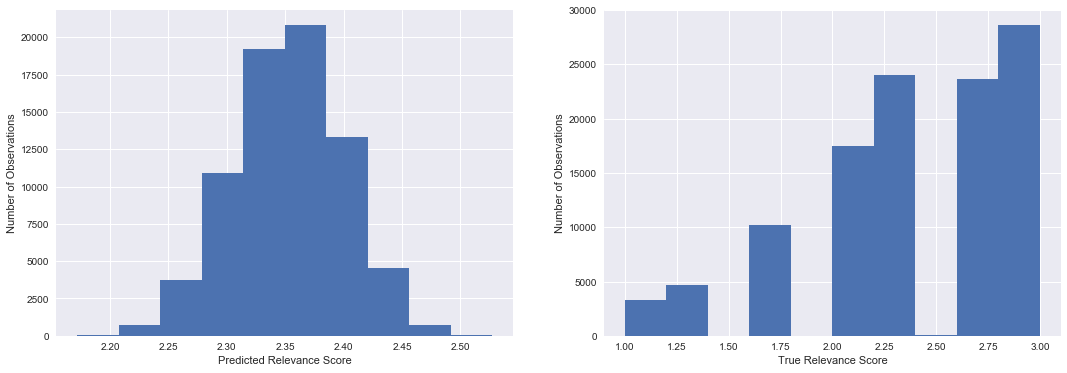

In [15]:
fig, ax = plt.subplots(1,1,figsize = (18,6))
ax = plt.subplot(1,2,1)
ax.hist(train_pred_list[np.argmin(dev_rmse_list)],bins = 10,label='Model Prediction')
ax1 = plt.subplot(1,2,2)
ax1.hist(list(dev_relevance),bins = 10,label='True Prediction')
ax.set_ylabel('Number of Observations')
ax1.set_ylabel('Number of Observations')
ax.set_xlabel('Predicted Relevance Score')
ax1.set_xlabel('True Relevance Score')
plt.show()
#fig.savefig('reports/fig/nnpredicted_true_relevance')